In [1]:
import pandas as pd
import numpy as np


In [2]:
def preprocess_features(runs_df):
    # convert some int columns to labels
    runs = runs_df.assign(leg_id=runs_df.leg_nro.astype(str))
    runs = runs.assign(num_runs=runs.num_runs.astype(str))
    runs = runs.drop(["leg_nro", "year", "team"], axis=1)
    
    # A columns that contains most poular first names or NA
    runs["first_name"] = runs.name.str.split(" ", expand=True).iloc[:,0]
    runs["first_name"].describe()
    counts = runs["first_name"].value_counts()
    top_counts = counts[counts > 30]

    runs["tfn"] = runs["first_name"]

    def top_name(first_name): 
        if first_name in top_counts:
            return first_name
        else:
            return  "NA"

    runs["tfn"] = runs.apply(lambda run: top_name(run["first_name"]), axis=1)
    display(top_counts.describe())
    
    # Explode categories to dummy columns
    features = pd.get_dummies(runs[["tfn", "leg_id", "num_runs", "team_country"]], sparse=True)
    # allow linear regression to fit non-linear terms
    features["team_id_log2"] = np.log2(runs.team_id)
    features["team_id_log10"] = np.log10(runs.team_id)
    features["team_id_log100"] = np.log(runs.team_id) / np.log(100)
    features["team_id_square"] = np.square(runs.team_id)
    
    features.insert(0, "team_id", runs["team_id"])

    import json
    with open(f"data/preprocess_priors_feature_columns.json", 'w') as outfile:
        json.dump(features.columns.tolist(), outfile)

    x = features.values
    #x = features[["team_id", "team_id_log10", "team_id_log100", "team_id_log2", "team_id_square", "leg_id_1", "leg_id_2", "leg_id_3", "leg_id_4", "leg_id_5", "leg_id_6", "leg_id_7"]].values # Poista tää.
    y = np.log(runs.pace.values)
    y = y.reshape(len(y), 1)
    
    display(x.shape)
    display(y.shape)

    return (features, x, y)

In [3]:
in_file_name = 'data/runs_ju.tsv'
runs_df = pd.read_csv(in_file_name, delimiter="\t")

(features, x, y) = preprocess_features(runs_df)


count     342.000000
mean      181.415205
std       260.253424
min        31.000000
25%        45.000000
50%        76.000000
75%       188.500000
max      1787.000000
Name: first_name, dtype: float64

(76531, 398)

(76531, 1)

In [4]:
features.head(10)

,team_id,tfn_,tfn_NA,tfn_aapo,tfn_aarne,tfn_aaro,tfn_adam,tfn_aimo,tfn_aino,tfn_aki,...,team_country_SLO,team_country_SRB,team_country_SUI,team_country_SWE,team_country_UKR,team_country_USA,team_id_log2,team_id_log10,team_id_log100,team_id_square
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.000000,0.301030,0.150515,4
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.000000,1.204120,0.602060,256
2,143,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7.159871,2.155336,1.077668,20449
3,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.584963,1.079181,0.539591,144
4,37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5.209453,1.568202,0.784101,1369
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.000000,0.301030,0.150515,4
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,1
7,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.169925,0.954243,0.477121,81
8,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.584963,1.079181,0.539591,144
9,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.392317,1.322219,0.661110,441


In [5]:
features.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 76531 entries, 0 to 76530
Columns: 398 entries, team_id to team_id_square
dtypes: Sparse[float64, nan](3), Sparse[int64, nan](2), Sparse[uint8, 0](393)
memory usage: 4.4 MB


In [6]:
import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.95, random_state=2019)
x_train.shape

(3826, 398)

In [12]:
import matplotlib.pyplot as plt
def fit_and_test_model(model, x_train, x_test, y_train, y_test, fit_params={}):
    model.fit(x_train, y_train.ravel(), **fit_params)
    y_pred = np.exp(model.predict(x_test))
    print(f"Shapes: y_test={np.exp(y_test).shape} y_pred={y_pred.shape}")
    print("Mean squared error: %.3f" % mean_squared_error(np.exp(y_test), y_pred))
    print('Explained variance score: %.3f' % r2_score(np.exp(y_test), y_pred))
    
    plt.scatter(x_test[:,0], np.exp(y_test),  color='red', alpha=0.01)
    plt.scatter(x_test[:,0], y_pred, color='blue', alpha=0.01)
    plt.ylim(4, 20)
    plt.show()

In [13]:
y_train.shape

(3826, 1)

Shapes: y_test=(72705, 1) y_pred=(72705,)
Mean squared error: 6.321
Explained variance score: 0.287


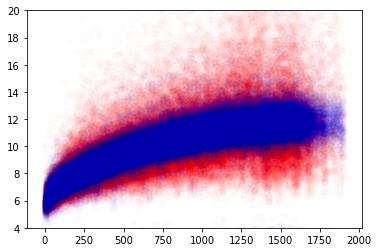

CPU times: user 3.98 s, sys: 437 ms, total: 4.42 s
Wall time: 2.52 s


In [14]:
%%time
linear = linear_model.LinearRegression()
fit_and_test_model(linear, x_train, x_test, y_train, y_test)

      Iter       Train Loss   Remaining Time 
         1           0.0621            3.36m
         2           0.0574            3.09m
         3           0.0535            3.03m
         4           0.0504            3.00m
         5           0.0477            3.11m
         6           0.0456            3.20m
         7           0.0438            3.27m
         8           0.0422            3.27m
         9           0.0410            3.23m
        10           0.0399            3.19m
        20           0.0351            3.16m
        30           0.0335            2.92m
        40           0.0326            2.68m
        50           0.0321            2.46m
        60           0.0316            2.32m
        70           0.0313            2.19m
        80           0.0310            2.13m
        90           0.0307            2.08m
       100           0.0305            2.06m
       200           0.0288            1.74m
       300           0.0273            1.71m
       40

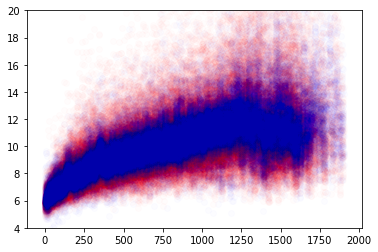

CPU times: user 1min 53s, sys: 422 ms, total: 1min 53s
Wall time: 1min 53s


In [15]:
%%time

gbr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=5100, random_state=0, verbose=1)

fit_and_test_model(gbr, x_train, x_test, y_train, y_test)

#print(f"feature_importances_: {gbr.feature_importances_}")
#gbr_features = pd.DataFrame({'feature':first_names.columns, 'importance': gbr.feature_importances_})
#gbr_features['feature'] = gbr_features['feature'].str.replace('top_first_name_','')
#display(gbr_features.sort_values(by="importance", ascending=False))

In [16]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
#os.environ['THEANO_FLAGS'] = 'device=cpu'
os.environ['THEANO_FLAGS'] = 'device=cuda,floatX=float32,force_device=True'

import pymc3 as pm
import pmlearn
from pmlearn.linear_model import LinearRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))


ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None


Running on pymc-learn v0.0.1.rc3


In [18]:
import multiprocessing
multiprocessing.cpu_count()

12

In [19]:
pmlearn_linear = LinearRegression()
fit_params={
    "inference_type": "nuts",
    "inference_args": {
        "cores": 2 * multiprocessing.cpu_count()
    }
}
fit_and_test_model(pmlearn_linear, pd.DataFrame(data=x_train), pd.DataFrame(x_test), y_train, y_test,fit_params)

Multiprocess sampling (24 chains in 24 jobs)
NUTS: [s, betas, alpha]
Sampling 24 chains: 100%|██████████| 24000/24000 [11:36:49<00:00, 12.23s/draws]     
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.06393717898119711, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.05737297182588822, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.05034390045744729, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.090373224

Shapes: y_test=(72705, 1) y_pred=(72705,)
Mean squared error: 1976823122038089446326272.000
Explained variance score: -223118375709818637778944.000


TypeError: '(slice(None, None, None), 0)' is an invalid key

In [20]:
pmlearn_preds = pmlearn_linear.predict(pd.DataFrame(x_test), return_std=True)

100%|██████████| 2000/2000 [13:45<00:00,  2.40it/s]


In [21]:
pred_errors = pd.DataFrame({
    'mean':np.exp(pmlearn_preds[0]), 
    'std':np.exp(pmlearn_preds[1]), 
    'true':np.exp(y_test).ravel(), 
    'error':np.abs(np.exp(y_test).ravel() -np.exp(pmlearn_preds[0])) / np.exp(pmlearn_preds[1])
})
display(pred_errors.head(10))
pred_errors.error.mean()

,mean,std,true,error
0,10.745193,1.210056,12.845,1.735297
1,11.629231,1.210237,13.346,1.418539
2,12.614790,1.198144,15.231,2.183553
3,9.158830,1.235211,7.519,1.327571
4,10.158598,1.201393,9.995,0.136174
5,11.257056,1.206390,16.593,4.423068
6,9.237089,1.206005,10.448,1.004068
7,12.012418,1.208790,10.327,1.394302
8,13.421578,1.208434,9.436,3.298135
9,11.920228,1.203975,11.572,0.289232


1.3461747693222366

In [ ]:
pmlearn_linear.plot_elbo()

In [ ]:
pm.traceplot(pmlearn_linear.trace)

In [ ]:
pm.forestplot(pmlearn_linear.trace, varnames=["betas", "alpha", "s"]);

In [ ]:
pm.summary(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])

In [ ]:
pm.plot_posterior(pmlearn_linear.trace, varnames=["betas", "alpha", "s"],
                 figsize = [14, 8])

In [ ]:
pm.gelman_rubin(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])